In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict

from dotenv import load_dotenv
load_dotenv()

# data selection imports
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [3]:
start =  datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2C02'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
SS1_path = data_root + "data/nw2/tracked_modes/SS1_" + name_location  + ".parquet"
SS2_path = data_root + "data/nw2/tracked_modes/SS2_" + name_location  + ".parquet"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
SS1_tracked = pd.read_parquet(SS1_path)
SS2_tracked = pd.read_parquet(SS2_path)

SS1_sorted = SS1_tracked.sort_values(['timestamp', 'size'])
SS1_sorted[SS1_sorted.index.duplicated(keep='last')]
SS1_drop_duplicates = SS1_sorted[~SS1_sorted.index.duplicated(keep='last')]

SS2_sorted = SS2_tracked.sort_values(['timestamp', 'size'])
SS2_sorted[SS2_sorted.index.duplicated(keep='last')]
SS2_drop_duplicates = SS2_sorted[~SS2_sorted.index.duplicated(keep='last')]

SS1_frequency = SS1_drop_duplicates.frequency
SS2_frequency = SS2_drop_duplicates.frequency

scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

selected_columns = \
    [
       #'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw',
       'mean_NW2_C02_pitch',
       'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'
    ]
inputs = inputs[selected_columns]

In [31]:
random_state = 24
test_size = 0.2
angle_transformed_inputs = sin_cos_angle_inputs(inputs)
angle_columns = [angle for angle in inputs.columns if ('yaw' in angle or 'winddirection' in angle)]
angle_removed_inputs = inputs.drop(columns=angle_columns)

prediction_param = SS2_frequency.copy()
y = prediction_param.dropna()
X = angle_transformed_inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=test_size, random_state=random_state)

from sklearn.preprocessing import StandardScaler
def data_preprocessing(X_train, X_test):
    "Apply standard scaling to the data"
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train, X_test
    
X_tr_prep, X_test_prep = data_preprocessing(X_train, X_test) 


In [32]:
import catboost as cb

cb_regr = cb.CatBoostRegressor(random_seed=13, verbose=200, posterior_sampling=True,
                          loss_function='RMSEWithUncertainty')
cb_regr.fit(X_train, y_train)


0:	learn: -2.5975840	total: 20.9ms	remaining: 20.9s
200:	learn: -3.2959982	total: 2.78s	remaining: 11.1s
400:	learn: -3.4215458	total: 5.54s	remaining: 8.28s
600:	learn: -3.4779130	total: 8.44s	remaining: 5.6s
800:	learn: -3.5239809	total: 11.2s	remaining: 2.78s
999:	learn: -3.5623502	total: 13.9s	remaining: 0us


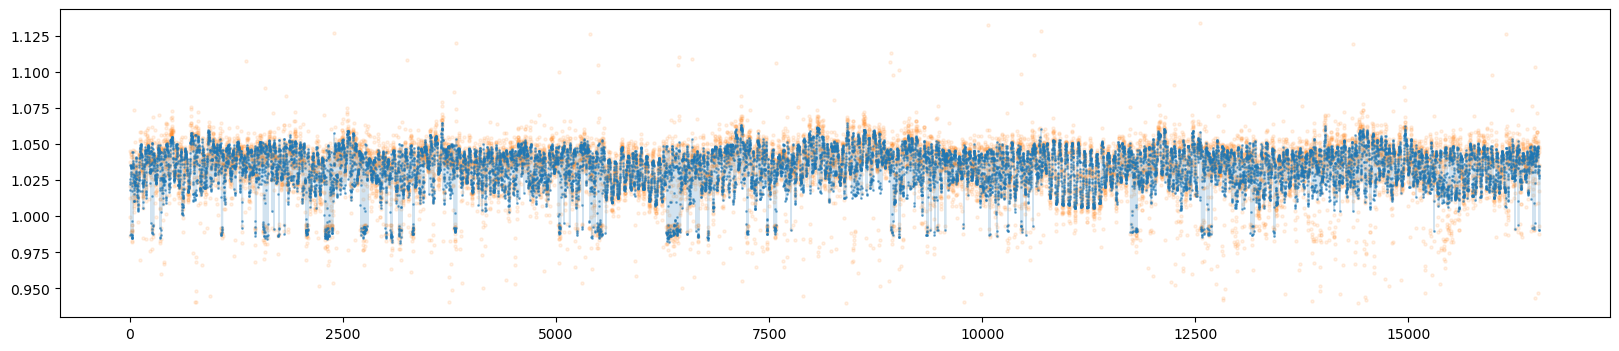

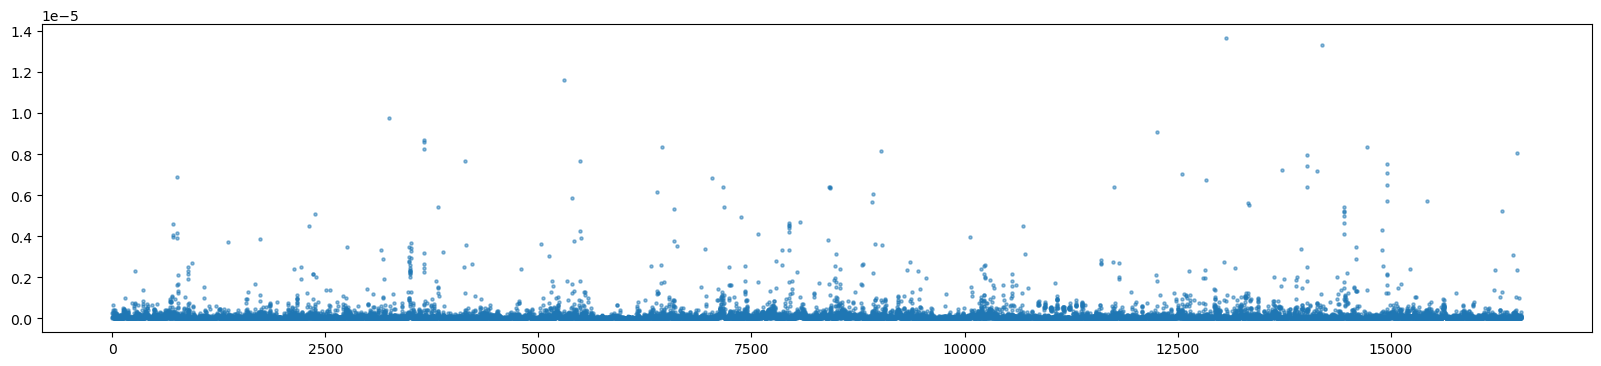

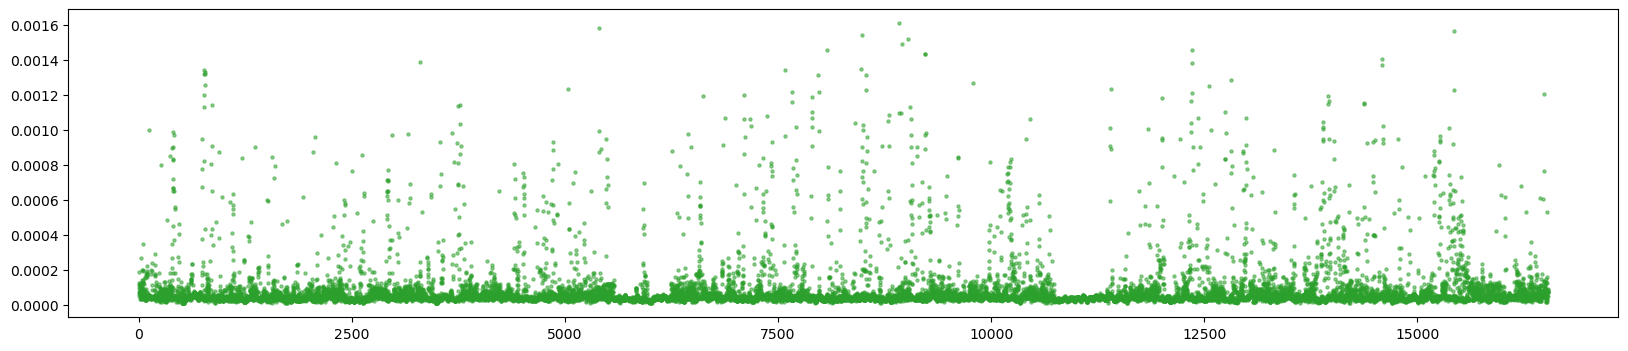

In [33]:
preds = cb_regr.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=100)

mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(y)), mean_preds, alpha=0.5, color='tab:blue', s=1)
plt.fill_between(range(len(y)), mean_preds-knowledge, mean_preds+knowledge, alpha = 0.2, color = 'tab:blue')
#plt.fill_between(range(len(y)), mean_preds-data, mean_preds+data, alpha = 0.2, color = 'tab:green')

#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.1, s=5, color = 'tab:green')
#plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.1, color = 'tab:green')

plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), knowledge, alpha=0.5, color='tab:blue',s=5)
plt.show()
plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), data, alpha=0.5, color='tab:green',s=5)
plt.show()

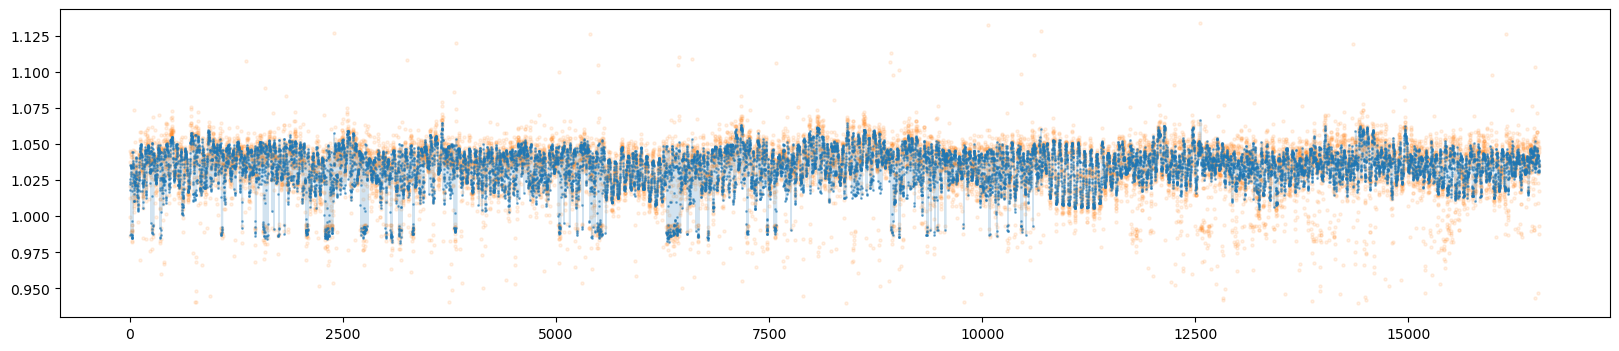

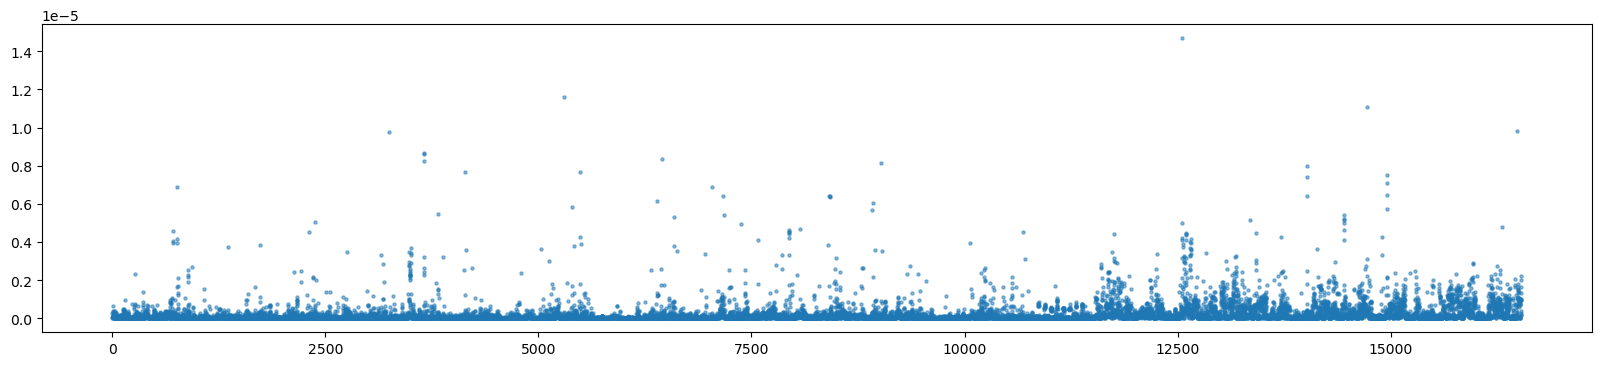

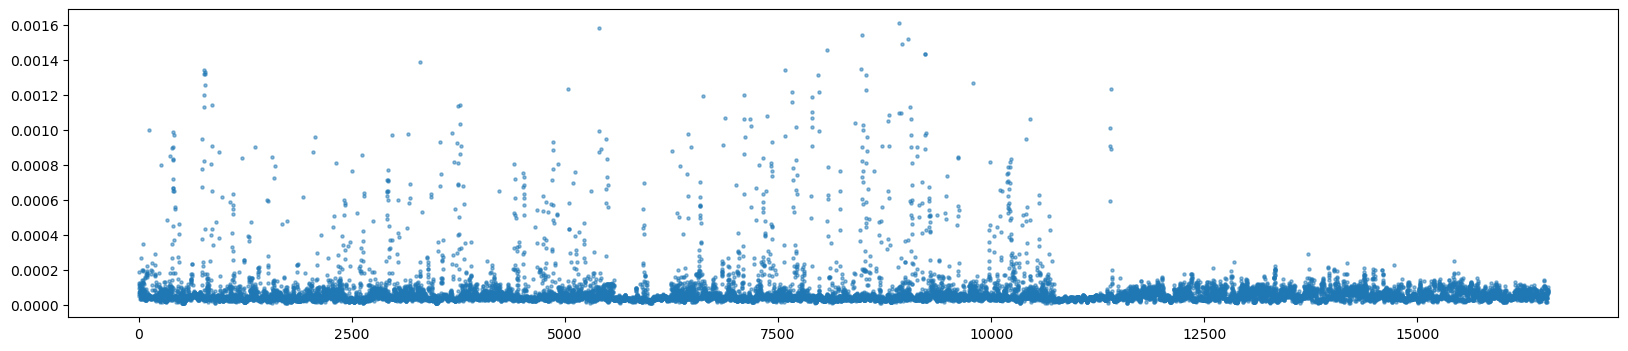

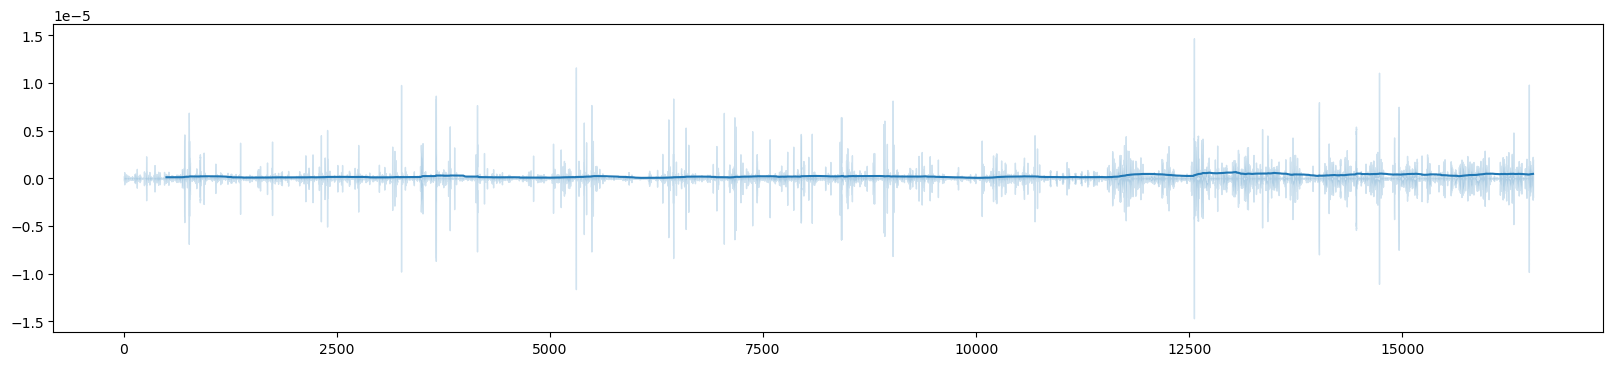

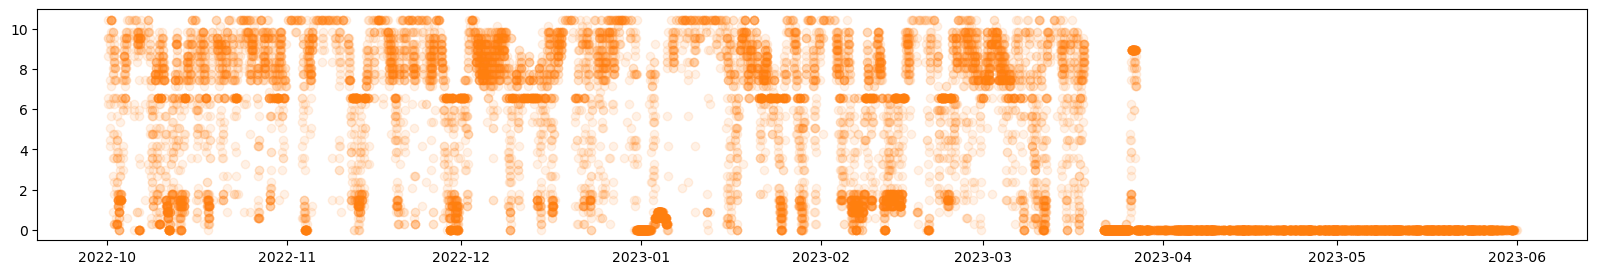

In [53]:
X_transformed = X.copy()
columns = 4
X_transformed.iloc[-5000:, columns] = 0
#predictions = ensemble_model.predict(X_test*5)
preds = cb_regr.virtual_ensembles_predict(X_transformed, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=100)

mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(y)), mean_preds, alpha=0.5, color='tab:blue', s=1)
plt.fill_between(range(len(y)), mean_preds-knowledge, mean_preds+knowledge, alpha = 0.2, color = 'tab:blue')
#plt.fill_between(range(len(y)), mean_preds-data, mean_preds+data, alpha = 0.2, color = 'tab:green')
plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), knowledge, alpha=0.5, color='tab:blue',s=5)
plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), data, alpha=0.5, color='tab:blue',s=5)
plt.show()

plt.figure(figsize=(20,4))
#plt.scatter(range(len(y.iloc[12000:])), y.iloc[12000:], alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(knowledge)), -knowledge, +knowledge, alpha = 0.2, color = 'tab:blue')
plt.plot(pd.DataFrame(knowledge).rolling(500).mean())
plt.show()

plt.figure(figsize=(20,3))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

In [14]:
X_transformed.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_pitch', 'mean_NW2_C02_power', 'mean_NW2_C02_windspeed',
       'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
       'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection'],
      dtype='object')

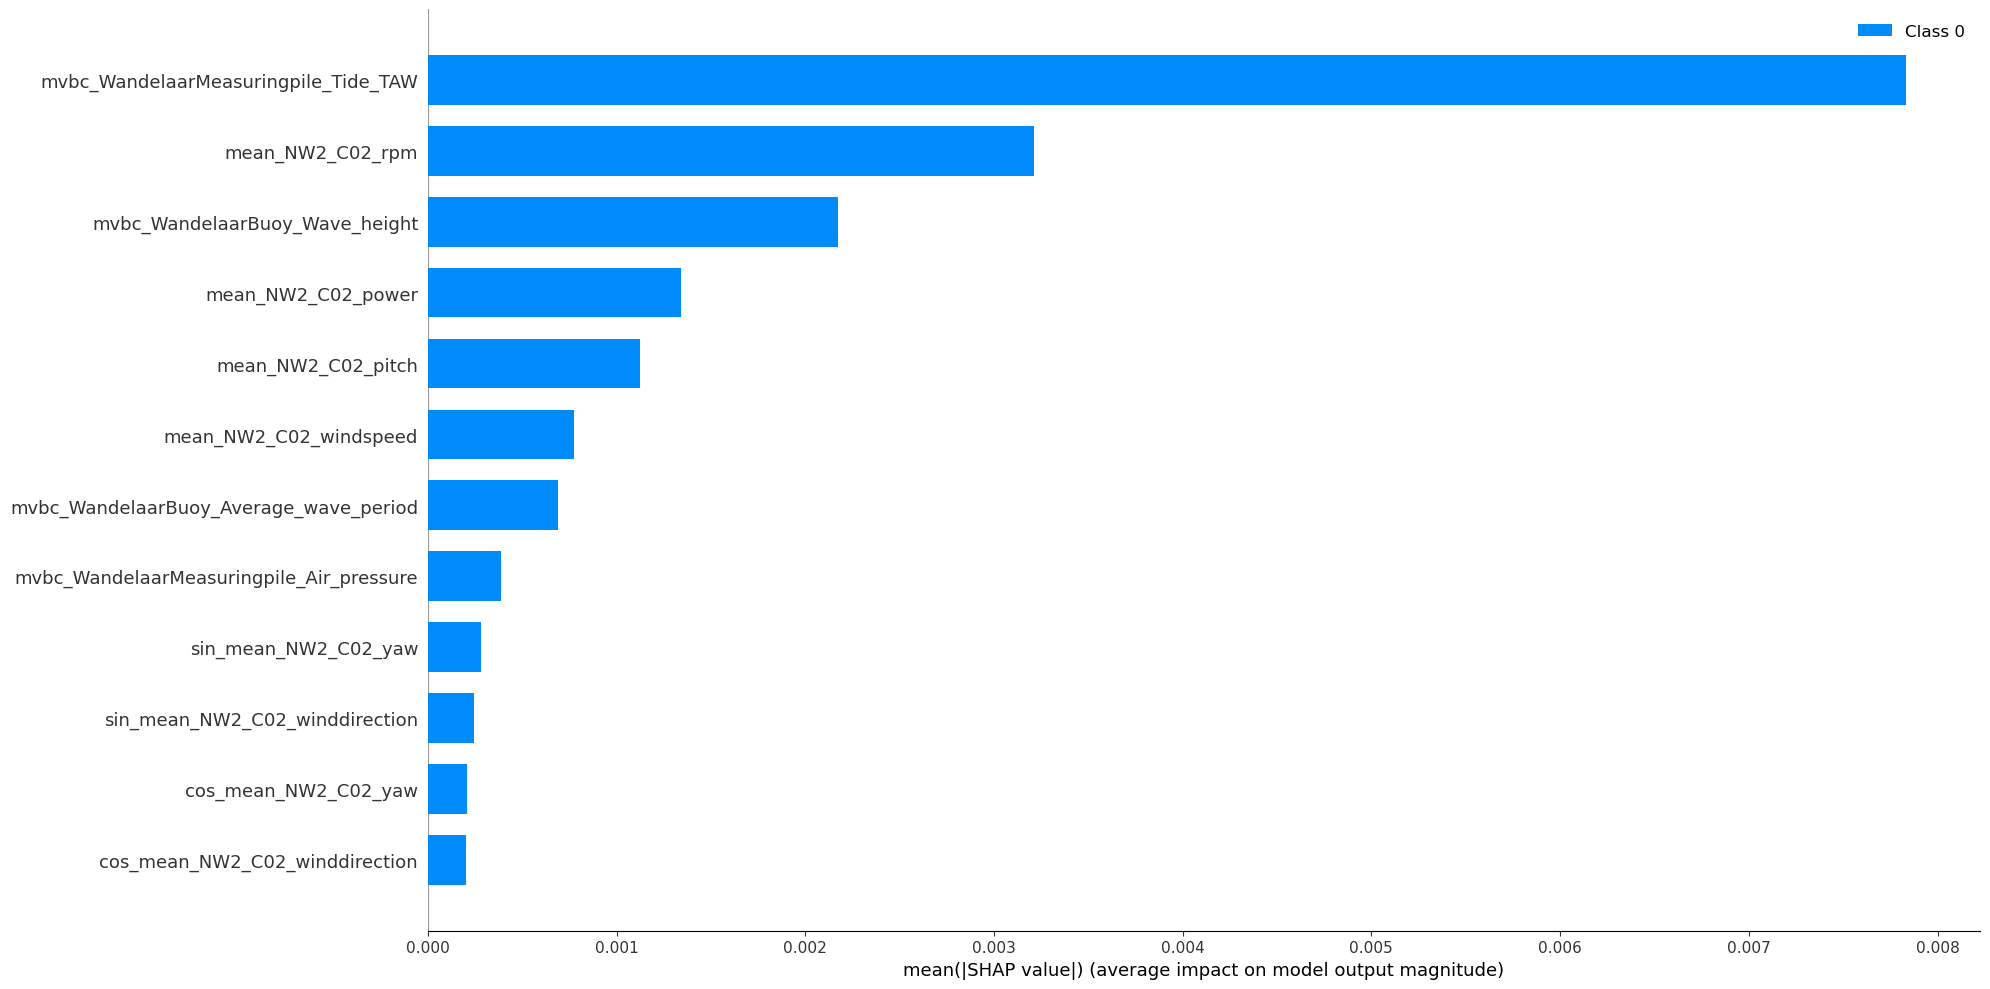

In [37]:
import shap
# SS1: All data
y = SS2_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

explainer = shap.TreeExplainer(cb_regr)
shap_value = explainer.shap_values(X)
shap.summary_plot(shap_value, X, plot_size=(20, 10))

## XGB

In [44]:
import numpy as np
from xgboost import XGBRegressor
from oma_tracking.models.virtual_ensemble import VirtualEnsembleXGB

# Example usage
n_estimators = 50

xgb_model = XGBRegressor(n_estimators=n_estimators)
xgb_model.fit(X_train, y_train)

n_submodels = int(n_estimators/2)
ensemble_model = VirtualEnsembleXGB(xgb_model, n_submodels)
predictions = ensemble_model.predict(X)
mean_predictions = ensemble_model.mean_predictions(X)
std_predictions = ensemble_model.std_predictions(X)


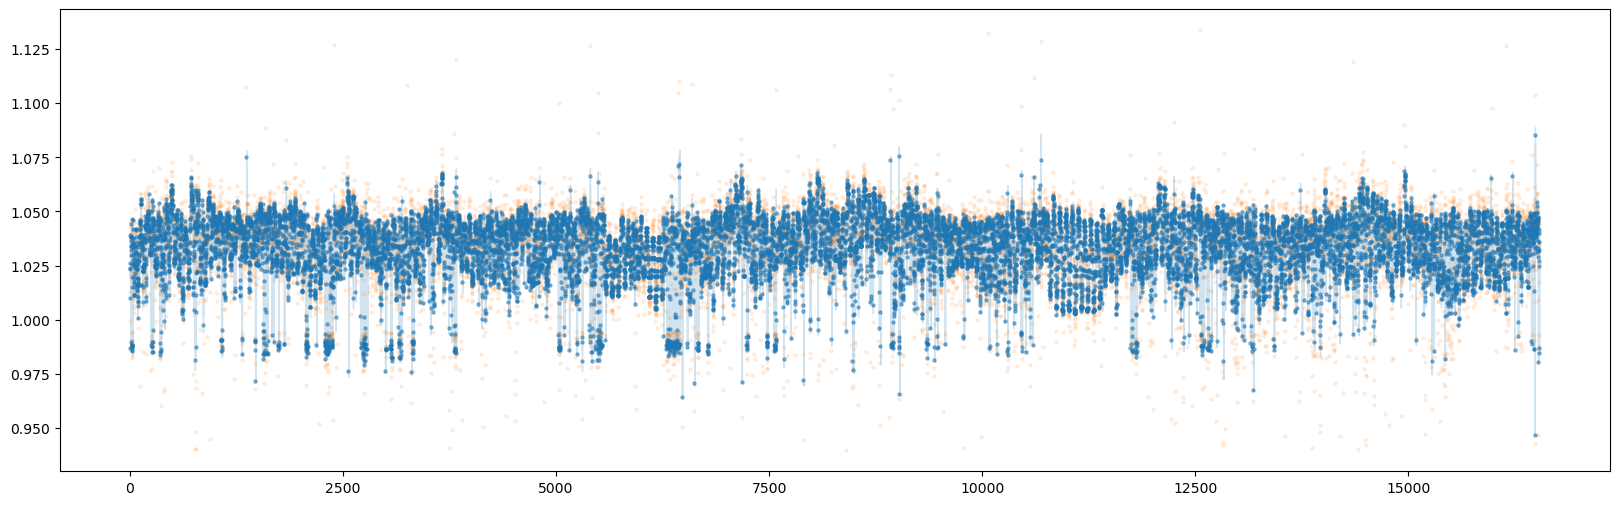

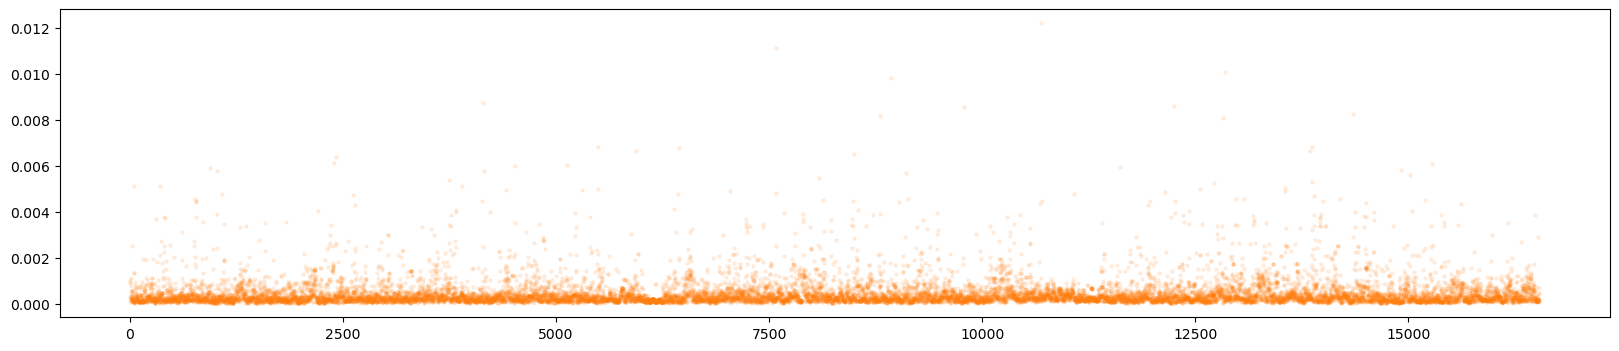

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.5, s=5)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
#plt.scatter(range(len(xgb_model.predict(X))), xgb_model.predict(X), alpha=0.5)
plt.show()
plt.figure(figsize=(20,4))
plt.scatter(range(len(std_predictions)), std_predictions, alpha=0.1, color='tab:orange', s=5)


In [48]:
# Example usage
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X, y)

n_submodels = 20
ensemble_model = VirtualEnsembleXGB(xgb_model, n_submodels)
predictions = ensemble_model.predict(X_test)

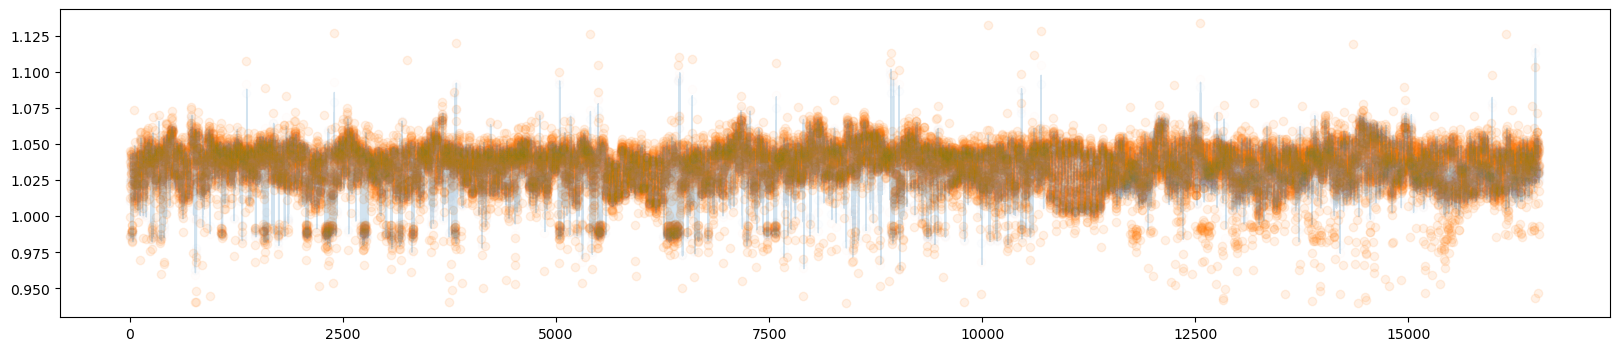

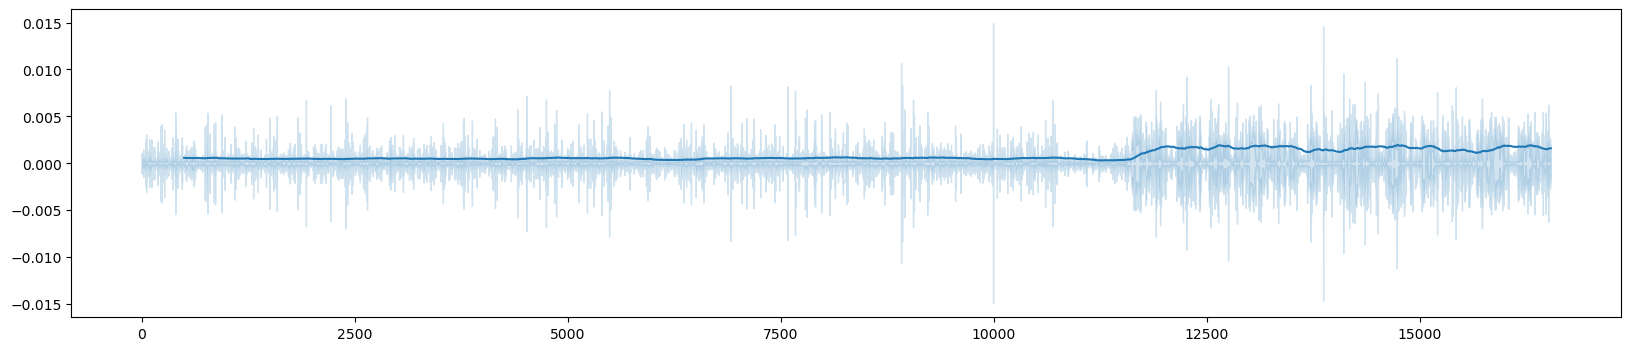

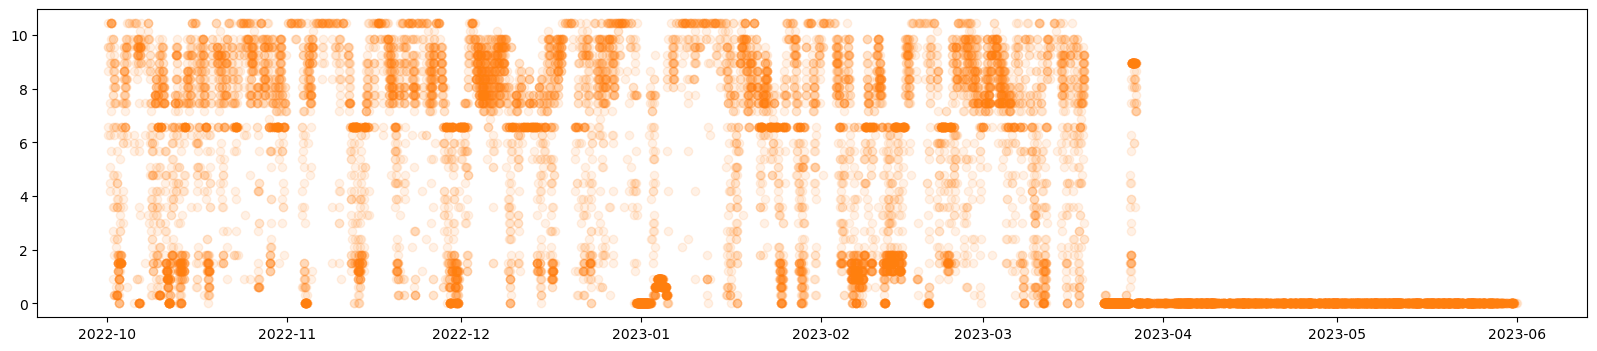

In [51]:
X_transformed = X.copy()
columns = 4
X_transformed.iloc[-5000:, columns] = 0

mean_predictions = ensemble_model.mean_predictions(X_transformed)
std_predictions = ensemble_model.std_predictions(X_transformed)

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange')
plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.01)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
plt.scatter(range(len(xgb_model.predict(X_transformed))), xgb_model.predict(X_transformed), alpha=0.01)
plt.show()

plt.figure(figsize=(20,4))
#plt.scatter(range(len(y.iloc[12000:])), y.iloc[12000:], alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(std_predictions)), -std_predictions, +std_predictions, alpha = 0.2, color = 'tab:blue')
plt.plot(pd.DataFrame(std_predictions).rolling(500).mean())
plt.show()

plt.figure(figsize=(20,4))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')